In [3]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import pickle

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.inspection import permutation_importance

from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel

from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFE

import xgboost as xgb
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import precision_recall_curve

from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import KNeighborsClassifier
from imblearn.over_sampling import SMOTE


## SVM

In [11]:
def train_and_evaluate_svm(dataset=""):
    if "voice" in dataset: 
        df = pd.read_csv(dataset)
        df = df.drop(columns=['voiceID'])
        df = df.sample(n=len(df))

    elif "HandMotion" in dataset:
        df = pd.read_csv(dataset)
        df = df.sample(n=len(df))
    else:
        df = pd.read_csv(dataset)
        df = df.sample(n=len(df))

    X = df.drop(columns="label")
    y = df["label"]
    
    kernels = ["linear", "rbf", "poly", "sigmoid"]
    param_grid = {
        "C": [0.1, 1, 10, 100],  
        "gamma": ["scale", "auto", 0.01, 0.1, 1]  
    }
    
    best_overall_model = None
    best_overall_score = 0
    final_conf_matrix = None
    results_list = []
    
    for seed in range(10):  # Try 10 different random seeds
        print(f"\nRunning experiment with random seed {seed}...")
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=0.2, random_state=seed, stratify=y
        )
        
        scaler = StandardScaler()
        X_train = scaler.fit_transform(X_train)
        X_test = scaler.transform(X_test)

        if "voice" in dataset: 
            with open("trained_models/scaler_v.pkl", "wb") as f:
                pickle.dump(scaler, f)
        elif "HandMotion" in dataset:
            with open("trained_models/scaler_HM.pkl", "wb") as f:
                pickle.dump(scaler, f)
        else:
            with open("trained_models/scaler_RT.pkl", "wb") as f:
                pickle.dump(scaler, f)
        
        pca = PCA(n_components=0.95)  # Keep 95% variance
        X_train = pca.fit_transform(X_train)
        X_test = pca.transform(X_test)

        if "voice" in dataset: 
            with open("trained_models/pca_v.pkl", "wb") as f:
                pickle.dump(pca, f)
        elif "HandMotion" in dataset:
            with open("trained_models/pca_HM.pkl", "wb") as f:
                pickle.dump(pca, f)
        else:
            with open("trained_models/pca_RT.pkl", "wb") as f:
                pickle.dump(pca, f)
        
        for kernel in kernels:
            print(f"Training SVM with {kernel} kernel (seed {seed})...")
            model = SVC(kernel=kernel, random_state=seed)
            grid_search = GridSearchCV(model, param_grid, scoring="accuracy", cv=5, n_jobs=-1)
            grid_search.fit(X_train, y_train)
            
            best_model = grid_search.best_estimator_
            best_params = grid_search.best_params_
            y_pred = best_model.predict(X_test)
            accuracy = accuracy_score(y_test, y_pred)
            report = classification_report(y_test, y_pred, output_dict=True)
            conf_matrix = confusion_matrix(y_test, y_pred)
            
            results_list.append({
                "Seed": seed,
                "Kernel": kernel,
                "Best C": best_params["C"],
                "Best Gamma": best_params["gamma"],
                "Accuracy": accuracy,
                "Precision": report["weighted avg"]["precision"],
                "Recall": report["weighted avg"]["recall"],
                "F1-score": report["weighted avg"]["f1-score"]
            })
            
            if accuracy > best_overall_score:
                best_overall_score = accuracy
                best_overall_model = best_model
                final_conf_matrix = conf_matrix  # Store best model's confusion matrix
                if "voice_" in dataset: 
                    model_filename = "trained_models/best_svm_model_voice.pkl"
                elif "HandMotion" in dataset:
                    model_filename = "trained_models/best_svm_model_HandMotion.pkl"
                else:
                    model_filename = "trained_models/best_svm_model_RestingTremor.pkl"  # Default case
                with open(model_filename, "wb") as f:
                    pickle.dump(best_model, f)  # Save best model

    results_df = pd.DataFrame(results_list)
    final_results = results_df.groupby("Kernel")[["Accuracy", "Precision", "Recall", "F1-score"]].agg(["mean", "std"])
    print("\nFinal Results Summary:")
    print(final_results)
    print("Best model saved as 'best_svm_model.pkl' with accuracy:", best_overall_score)
    
    if "voice_" in dataset: 
        final_results.to_csv("test_results/Int_testing_results_voice_SVM.csv")
    elif "HandMotion" in dataset:
        final_results.to_csv("test_results/Int_testing_results_HM_SVM.csv")
    else:
        final_results.to_csv("test_results/Int_testing_results_RT_SVM.csv")
   
    if final_conf_matrix is not None:
        plt.figure(figsize=(6, 4))
        sns.heatmap(final_conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=np.unique(y), yticklabels=np.unique(y))
        plt.xlabel("Predicted Label")
        plt.ylabel("True Label")
        plt.title("Final Confusion Matrix (Best Model)")
        plt.show()



Running experiment with random seed 0...
Training SVM with linear kernel (seed 0)...
Training SVM with rbf kernel (seed 0)...
Training SVM with poly kernel (seed 0)...
Training SVM with sigmoid kernel (seed 0)...

Running experiment with random seed 1...
Training SVM with linear kernel (seed 1)...
Training SVM with rbf kernel (seed 1)...
Training SVM with poly kernel (seed 1)...
Training SVM with sigmoid kernel (seed 1)...

Running experiment with random seed 2...
Training SVM with linear kernel (seed 2)...
Training SVM with rbf kernel (seed 2)...
Training SVM with poly kernel (seed 2)...
Training SVM with sigmoid kernel (seed 2)...

Running experiment with random seed 3...
Training SVM with linear kernel (seed 3)...
Training SVM with rbf kernel (seed 3)...
Training SVM with poly kernel (seed 3)...
Training SVM with sigmoid kernel (seed 3)...

Running experiment with random seed 4...
Training SVM with linear kernel (seed 4)...
Training SVM with rbf kernel (seed 4)...
Training SVM with

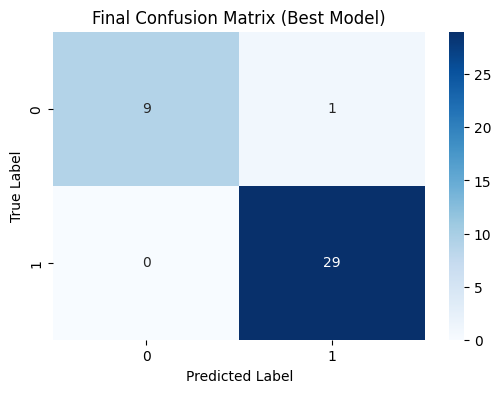

In [12]:
train_and_evaluate_svm("data_train/voice_UCI.csv")


Running experiment with random seed 0...
Training SVM with linear kernel (seed 0)...
Training SVM with rbf kernel (seed 0)...
Training SVM with poly kernel (seed 0)...
Training SVM with sigmoid kernel (seed 0)...

Running experiment with random seed 1...
Training SVM with linear kernel (seed 1)...
Training SVM with rbf kernel (seed 1)...
Training SVM with poly kernel (seed 1)...
Training SVM with sigmoid kernel (seed 1)...

Running experiment with random seed 2...
Training SVM with linear kernel (seed 2)...
Training SVM with rbf kernel (seed 2)...
Training SVM with poly kernel (seed 2)...
Training SVM with sigmoid kernel (seed 2)...

Running experiment with random seed 3...
Training SVM with linear kernel (seed 3)...
Training SVM with rbf kernel (seed 3)...
Training SVM with poly kernel (seed 3)...
Training SVM with sigmoid kernel (seed 3)...

Running experiment with random seed 4...
Training SVM with linear kernel (seed 4)...
Training SVM with rbf kernel (seed 4)...
Training SVM with

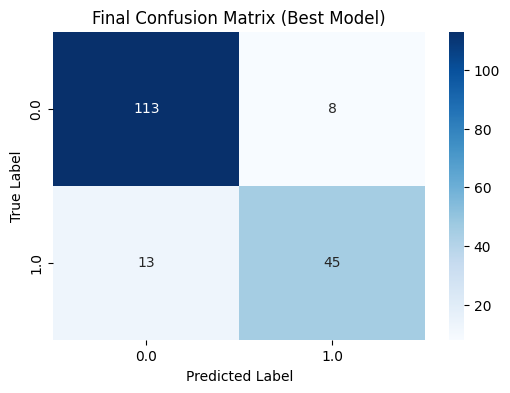

In [14]:
train_and_evaluate_svm("data_train/HandMotion_PaHaW.csv")


Running experiment with random seed 0...
Training SVM with linear kernel (seed 0)...
Training SVM with rbf kernel (seed 0)...
Training SVM with poly kernel (seed 0)...
Training SVM with sigmoid kernel (seed 0)...

Running experiment with random seed 1...
Training SVM with linear kernel (seed 1)...
Training SVM with rbf kernel (seed 1)...
Training SVM with poly kernel (seed 1)...
Training SVM with sigmoid kernel (seed 1)...

Running experiment with random seed 2...
Training SVM with linear kernel (seed 2)...
Training SVM with rbf kernel (seed 2)...
Training SVM with poly kernel (seed 2)...
Training SVM with sigmoid kernel (seed 2)...

Running experiment with random seed 3...
Training SVM with linear kernel (seed 3)...
Training SVM with rbf kernel (seed 3)...
Training SVM with poly kernel (seed 3)...
Training SVM with sigmoid kernel (seed 3)...

Running experiment with random seed 4...
Training SVM with linear kernel (seed 4)...
Training SVM with rbf kernel (seed 4)...
Training SVM with

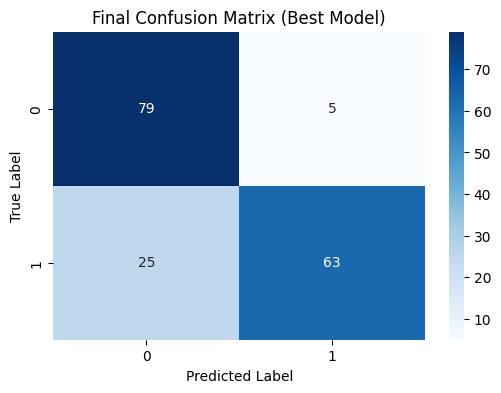

In [15]:
train_and_evaluate_svm("data_train/RT_Christina.csv")

## Random Forest

In [16]:
def train_and_evaluate_rf(dataset=""):
    if "voice" in dataset: 
        df = pd.read_csv(dataset)
        df = df.drop(columns="voiceID")
    elif "HandMotion" in dataset:
        df = pd.read_csv(dataset)
    else:
        df = pd.read_csv(dataset)
    
    # df = df.sample(frac=1).reset_index(drop=True)  # Shuffle dataset
    X = df.drop(columns="label")
    y = df["label"]
    
    param_grid = {
        "n_estimators": [100, 200, 300],
        "max_depth": [None, 10, 20],
        "min_samples_split": [2, 5, 10],
        "min_samples_leaf": [1, 2, 4],
        "max_features": ["sqrt", "log2"],
        "bootstrap": [True, False]
    }
    
    best_overall_model = None
    best_overall_score = 0
    final_conf_matrix = None
    results_list = []
    
    for seed in range(10):  # Try 10 different random seeds
        print(f"\nRunning experiment with random seed {seed}...")
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=0.2, random_state=seed, stratify=y
        )
        
        scaler = StandardScaler()
        X_train = scaler.fit_transform(X_train)
        X_test = scaler.transform(X_test)
        
        selector = SelectFromModel(RandomForestClassifier(n_estimators=100, random_state=seed))
        selector.fit(X_train, y_train)
        X_train = selector.transform(X_train)
        X_test = selector.transform(X_test)
        
        model = RandomForestClassifier(random_state=seed)
        grid_search = GridSearchCV(model, param_grid, scoring="accuracy", cv=10, n_jobs=-1)
        grid_search.fit(X_train, y_train)
        
        best_model = grid_search.best_estimator_
        best_params = grid_search.best_params_
        y_pred = best_model.predict(X_test)
        accuracy = accuracy_score(y_test, y_pred)
        report = classification_report(y_test, y_pred, output_dict=True)
        conf_matrix = confusion_matrix(y_test, y_pred)
        
        results_list.append({
            "Seed": seed,
            "Best n_estimators": best_params["n_estimators"],
            "Best max_depth": best_params["max_depth"],
            "Best min_samples_split": best_params["min_samples_split"],
            "Best min_samples_leaf": best_params["min_samples_leaf"],
            "Best max_features": best_params["max_features"],
            "Accuracy": accuracy,
            "Precision": report["weighted avg"]["precision"],
            "Recall": report["weighted avg"]["recall"],
            "F1-score": report["weighted avg"]["f1-score"]
        })
        
        if accuracy > best_overall_score:
            best_overall_score = accuracy
            best_overall_model = best_model
            final_conf_matrix = conf_matrix  # Store best model's confusion matrix
            # model_filename = f"trained_models/best_rf_model_{dataset}.pkl"

            if "voice_" in dataset: 
                model_filename = "trained_models/best_rf_model_voice.pkl"
            elif "HandMotion" in dataset:
                model_filename = "trained_models/best_rf_model_HM.pkl"
            else:
                model_filename = "trained_models/best_rf_model_RT.pkl"  # Default case
            with open(model_filename, "wb") as f:
                pickle.dump(best_model, f)  # Save best model

    
    results_df = pd.DataFrame(results_list)
    final_results = results_df.groupby("Seed")["Accuracy"].agg(["mean", "std"])
    print("\nFinal Results Summary:")
    print(final_results)
    # print(f"Best model saved as 'best_rf_model_.pkl' with accuracy:", best_overall_score)
    
    if "voice_" in dataset: 
        results_df.to_csv(f"test_results/Int_testing_results_voice_RF.csv")
    elif "HandMotion" in dataset:
        results_df.to_csv(f"test_results/Int_testing_results_HM_RF.csv")
    else:
        results_df.to_csv(f"test_results/Int_testing_results_RT_RF.csv")  # Default case

    if final_conf_matrix is not None:
        plt.figure(figsize=(6, 4))
        sns.heatmap(final_conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=np.unique(y), yticklabels=np.unique(y))
        plt.xlabel("Predicted Label")
        plt.ylabel("True Label")
        plt.title("Final Confusion Matrix (Best Model)")
        plt.show()



Running experiment with random seed 0...

Running experiment with random seed 1...

Running experiment with random seed 2...

Running experiment with random seed 3...

Running experiment with random seed 4...

Running experiment with random seed 5...

Running experiment with random seed 6...

Running experiment with random seed 7...

Running experiment with random seed 8...

Running experiment with random seed 9...

Final Results Summary:
          mean  std
Seed               
0     0.846154  NaN
1     0.897436  NaN
2     0.974359  NaN
3     0.897436  NaN
4     0.923077  NaN
5     0.846154  NaN
6     0.923077  NaN
7     0.948718  NaN
8     0.948718  NaN
9     0.897436  NaN


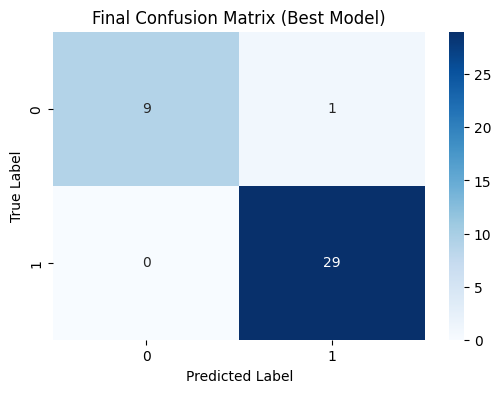


Running experiment with random seed 0...

Running experiment with random seed 1...

Running experiment with random seed 2...

Running experiment with random seed 3...

Running experiment with random seed 4...

Running experiment with random seed 5...

Running experiment with random seed 6...

Running experiment with random seed 7...

Running experiment with random seed 8...

Running experiment with random seed 9...

Final Results Summary:
          mean  std
Seed               
0     0.832402  NaN
1     0.837989  NaN
2     0.815642  NaN
3     0.821229  NaN
4     0.882682  NaN
5     0.810056  NaN
6     0.888268  NaN
7     0.860335  NaN
8     0.787709  NaN
9     0.865922  NaN


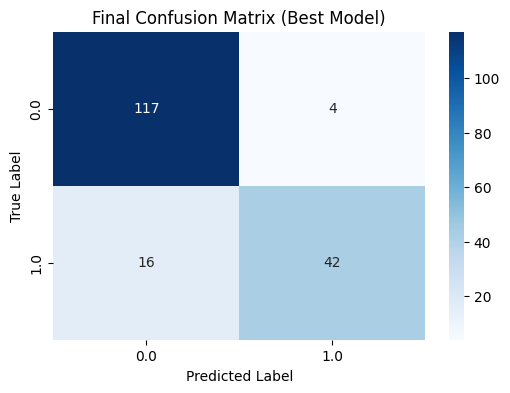


Running experiment with random seed 0...

Running experiment with random seed 1...

Running experiment with random seed 2...

Running experiment with random seed 3...

Running experiment with random seed 4...

Running experiment with random seed 5...

Running experiment with random seed 6...

Running experiment with random seed 7...

Running experiment with random seed 8...

Running experiment with random seed 9...

Final Results Summary:
          mean  std
Seed               
0     0.796512  NaN
1     0.767442  NaN
2     0.819767  NaN
3     0.773256  NaN
4     0.796512  NaN
5     0.813953  NaN
6     0.808140  NaN
7     0.819767  NaN
8     0.779070  NaN
9     0.796512  NaN


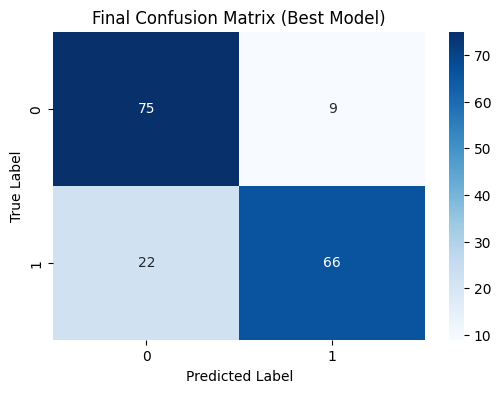

In [17]:
train_and_evaluate_rf("data_train/voice_UCI.csv")
train_and_evaluate_rf("data_train/HandMotion_PaHaW.csv")
train_and_evaluate_rf("data_train/RT_Christina.csv")

In [18]:
# train_and_evaluate_rf("/home/varsallz/Diagnostic_Aid_PD/code/Algorithm/HandMotion/HandMotion_PaHaW.csv")

In [19]:
# train_and_evaluate_rf("/home/varsallz/Diagnostic_Aid_PD/code/Algorithm/tremor/RT_features.csv")

## Logistic Regression

In [20]:
def train_and_evaluate_lr(dataset=""):
    if "voice" in dataset: 
        df = pd.read_csv(dataset)
        df = df.drop(columns="voiceID")
    elif "HandMotion" in dataset:
        df = pd.read_csv(dataset)
    else:
        df = pd.read_csv(dataset)
    
    df = df.sample(frac=1).reset_index(drop=True)  # Shuffle dataset
    X = df.drop(columns="label")
    y = df["label"]
    
    param_grid = {
        "C": [0.01, 0.1, 1, 10, 100],
        "penalty": ["l1", "l2"],
        "solver": ["liblinear", "saga"]
    }
    
    best_overall_model = None
    best_overall_score = 0
    final_conf_matrix = None
    results_list = []
    
    for seed in range(10):  # Try 10 different random seeds
        print(f"\nRunning experiment with random seed {seed}...")
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=0.2, random_state=seed, stratify=y
        )
        
        scaler = StandardScaler()
        X_train = scaler.fit_transform(X_train)
        X_test = scaler.transform(X_test)
        
        
        rfe = RFE(LogisticRegression(max_iter=5000), n_features_to_select=10)
        X_train = rfe.fit_transform(X_train, y_train)
        X_test = rfe.transform(X_test)
        
        if "voice" in dataset: 
            with open("trained_models/rfe_v.pkl", "wb") as f:
                pickle.dump(rfe, f)
        elif "HandMotion" in dataset:
            with open("trained_models/rfe_HM.pkl", "wb") as f:
                pickle.dump(rfe, f)
        else:
            with open("trained_models/rfe_RT.pkl", "wb") as f:
                pickle.dump(rfe, f)
        
        model = LogisticRegression(max_iter=1000)
        grid_search = GridSearchCV(model, param_grid, scoring="accuracy", cv=10, n_jobs=-1)
        grid_search.fit(X_train, y_train)
        
        best_model = grid_search.best_estimator_
        best_params = grid_search.best_params_
        y_pred = best_model.predict(X_test)
        accuracy = accuracy_score(y_test, y_pred)
        report = classification_report(y_test, y_pred, output_dict=True)
        conf_matrix = confusion_matrix(y_test, y_pred)
        
        results_list.append({
            "Seed": seed,
            "Best C": best_params["C"],
            "Best Penalty": best_params["penalty"],
            "Best Solver": best_params["solver"],
            "Accuracy": accuracy,
            "Precision": report["weighted avg"]["precision"],
            "Recall": report["weighted avg"]["recall"],
            "F1-score": report["weighted avg"]["f1-score"]
        })
        
        if accuracy > best_overall_score:
            best_overall_score = accuracy
            best_overall_model = best_model
            final_conf_matrix = conf_matrix  # Store best model's confusion matrix
            if "voice_" in dataset: 
                model_filename = "trained_models/best_LR_model_voice.pkl"
            elif "HandMotion" in dataset:
                model_filename = "trained_models/best_LR_model_HM.pkl"
            else:
                model_filename = "trained_models/best_LR_model_RT.pkl"  # Default case
            with open(model_filename, "wb") as f:
                pickle.dump(best_model, f)  # Save best model

    
    results_df = pd.DataFrame(results_list)
    final_results = results_df.groupby("Seed")["Accuracy"].agg(["mean", "std"])
    print("\nFinal Results Summary:")
    print(final_results)
    # print(f"Best model saved as 'best_lr_model_{dataset}.pkl' with accuracy:", best_overall_score)
    
    if "voice_" in dataset: 
        results_df.to_csv(f"test_results/Int_testing_results_voice_LR.csv")
    elif "HandMotion" in dataset:
        results_df.to_csv(f"test_results/Int_testing_results_HM_LR.csv")
    else:
        results_df.to_csv(f"test_results/Int_testing_results_RT_LR.csv")  # Default case

    
    if final_conf_matrix is not None:
        plt.figure(figsize=(6, 4))
        sns.heatmap(final_conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=np.unique(y), yticklabels=np.unique(y))
        plt.xlabel("Predicted Label")
        plt.ylabel("True Label")
        plt.title("Final Confusion Matrix (Best Model)")
        plt.show()



Running experiment with random seed 0...


/home/varsallz/Diagnostic_Aid_PD/.venv/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/varsallz/Diagnostic_Aid_PD/.venv/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/varsallz/Diagnostic_Aid_PD/.venv/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/varsallz/Diagnostic_Aid_PD/.venv/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/varsallz/Diagnostic_Aid_PD/.venv/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  


Running experiment with random seed 1...


/home/varsallz/Diagnostic_Aid_PD/.venv/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/varsallz/Diagnostic_Aid_PD/.venv/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/varsallz/Diagnostic_Aid_PD/.venv/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/varsallz/Diagnostic_Aid_PD/.venv/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/varsallz/Diagnostic_Aid_PD/.venv/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  


Running experiment with random seed 2...


/home/varsallz/Diagnostic_Aid_PD/.venv/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/varsallz/Diagnostic_Aid_PD/.venv/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/varsallz/Diagnostic_Aid_PD/.venv/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/varsallz/Diagnostic_Aid_PD/.venv/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/varsallz/Diagnostic_Aid_PD/.venv/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  


Running experiment with random seed 3...


/home/varsallz/Diagnostic_Aid_PD/.venv/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/varsallz/Diagnostic_Aid_PD/.venv/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/varsallz/Diagnostic_Aid_PD/.venv/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/varsallz/Diagnostic_Aid_PD/.venv/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/varsallz/Diagnostic_Aid_PD/.venv/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  


Running experiment with random seed 4...


/home/varsallz/Diagnostic_Aid_PD/.venv/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/varsallz/Diagnostic_Aid_PD/.venv/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/varsallz/Diagnostic_Aid_PD/.venv/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/varsallz/Diagnostic_Aid_PD/.venv/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/varsallz/Diagnostic_Aid_PD/.venv/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  


Running experiment with random seed 5...


/home/varsallz/Diagnostic_Aid_PD/.venv/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/varsallz/Diagnostic_Aid_PD/.venv/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/varsallz/Diagnostic_Aid_PD/.venv/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/varsallz/Diagnostic_Aid_PD/.venv/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/varsallz/Diagnostic_Aid_PD/.venv/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  


Running experiment with random seed 6...


/home/varsallz/Diagnostic_Aid_PD/.venv/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/varsallz/Diagnostic_Aid_PD/.venv/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/varsallz/Diagnostic_Aid_PD/.venv/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/varsallz/Diagnostic_Aid_PD/.venv/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/varsallz/Diagnostic_Aid_PD/.venv/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  


Running experiment with random seed 7...


/home/varsallz/Diagnostic_Aid_PD/.venv/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/varsallz/Diagnostic_Aid_PD/.venv/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/varsallz/Diagnostic_Aid_PD/.venv/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/varsallz/Diagnostic_Aid_PD/.venv/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/varsallz/Diagnostic_Aid_PD/.venv/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  


Running experiment with random seed 8...


/home/varsallz/Diagnostic_Aid_PD/.venv/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/varsallz/Diagnostic_Aid_PD/.venv/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/varsallz/Diagnostic_Aid_PD/.venv/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/varsallz/Diagnostic_Aid_PD/.venv/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/varsallz/Diagnostic_Aid_PD/.venv/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  


Running experiment with random seed 9...


/home/varsallz/Diagnostic_Aid_PD/.venv/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/varsallz/Diagnostic_Aid_PD/.venv/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/varsallz/Diagnostic_Aid_PD/.venv/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/varsallz/Diagnostic_Aid_PD/.venv/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/varsallz/Diagnostic_Aid_PD/.venv/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  


Final Results Summary:
          mean  std
Seed               
0     0.820513  NaN
1     0.820513  NaN
2     0.794872  NaN
3     0.820513  NaN
4     0.871795  NaN
5     0.794872  NaN
6     0.846154  NaN
7     0.923077  NaN
8     0.897436  NaN
9     0.769231  NaN


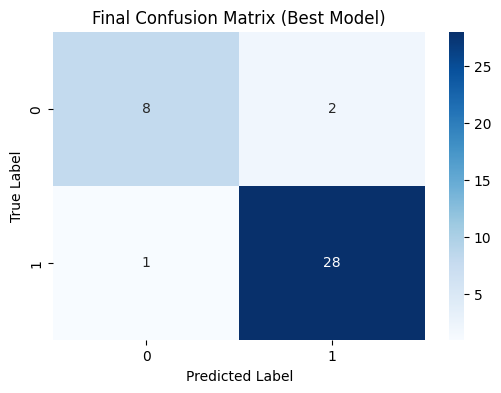


Running experiment with random seed 0...


/home/varsallz/Diagnostic_Aid_PD/.venv/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/varsallz/Diagnostic_Aid_PD/.venv/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/varsallz/Diagnostic_Aid_PD/.venv/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/varsallz/Diagnostic_Aid_PD/.venv/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/varsallz/Diagnostic_Aid_PD/.venv/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  


Running experiment with random seed 1...

Running experiment with random seed 2...


/home/varsallz/Diagnostic_Aid_PD/.venv/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/varsallz/Diagnostic_Aid_PD/.venv/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/varsallz/Diagnostic_Aid_PD/.venv/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/varsallz/Diagnostic_Aid_PD/.venv/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/varsallz/Diagnostic_Aid_PD/.venv/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  


Running experiment with random seed 3...


/home/varsallz/Diagnostic_Aid_PD/.venv/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/varsallz/Diagnostic_Aid_PD/.venv/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/varsallz/Diagnostic_Aid_PD/.venv/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/varsallz/Diagnostic_Aid_PD/.venv/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/varsallz/Diagnostic_Aid_PD/.venv/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  


Running experiment with random seed 4...


/home/varsallz/Diagnostic_Aid_PD/.venv/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/varsallz/Diagnostic_Aid_PD/.venv/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/varsallz/Diagnostic_Aid_PD/.venv/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/varsallz/Diagnostic_Aid_PD/.venv/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/varsallz/Diagnostic_Aid_PD/.venv/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  


Running experiment with random seed 5...


/home/varsallz/Diagnostic_Aid_PD/.venv/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/varsallz/Diagnostic_Aid_PD/.venv/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/varsallz/Diagnostic_Aid_PD/.venv/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/varsallz/Diagnostic_Aid_PD/.venv/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/varsallz/Diagnostic_Aid_PD/.venv/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  


Running experiment with random seed 6...


/home/varsallz/Diagnostic_Aid_PD/.venv/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/varsallz/Diagnostic_Aid_PD/.venv/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/varsallz/Diagnostic_Aid_PD/.venv/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/varsallz/Diagnostic_Aid_PD/.venv/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/varsallz/Diagnostic_Aid_PD/.venv/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  


Running experiment with random seed 7...


/home/varsallz/Diagnostic_Aid_PD/.venv/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/varsallz/Diagnostic_Aid_PD/.venv/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/varsallz/Diagnostic_Aid_PD/.venv/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/varsallz/Diagnostic_Aid_PD/.venv/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/varsallz/Diagnostic_Aid_PD/.venv/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  


Running experiment with random seed 8...


/home/varsallz/Diagnostic_Aid_PD/.venv/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/varsallz/Diagnostic_Aid_PD/.venv/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/varsallz/Diagnostic_Aid_PD/.venv/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/varsallz/Diagnostic_Aid_PD/.venv/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/varsallz/Diagnostic_Aid_PD/.venv/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  


Running experiment with random seed 9...


/home/varsallz/Diagnostic_Aid_PD/.venv/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/varsallz/Diagnostic_Aid_PD/.venv/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/varsallz/Diagnostic_Aid_PD/.venv/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/varsallz/Diagnostic_Aid_PD/.venv/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/varsallz/Diagnostic_Aid_PD/.venv/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  


Final Results Summary:
          mean  std
Seed               
0     0.726257  NaN
1     0.720670  NaN
2     0.698324  NaN
3     0.715084  NaN
4     0.692737  NaN
5     0.737430  NaN
6     0.715084  NaN
7     0.754190  NaN
8     0.698324  NaN
9     0.709497  NaN


/home/varsallz/Diagnostic_Aid_PD/.venv/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


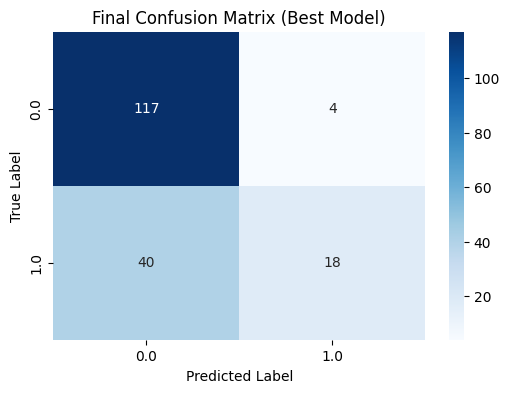

/home/varsallz/Diagnostic_Aid_PD/.venv/lib/python3.10/site-packages/sklearn/feature_selection/_rfe.py:300: UserWarning: Found n_features_to_select=10 > n_features=6. There will be no feature selection and all features will be kept.
  warnings.warn(



Running experiment with random seed 0...


/home/varsallz/Diagnostic_Aid_PD/.venv/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/varsallz/Diagnostic_Aid_PD/.venv/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/varsallz/Diagnostic_Aid_PD/.venv/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/varsallz/Diagnostic_Aid_PD/.venv/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/varsallz/Diagnostic_Aid_PD/.venv/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  


Running experiment with random seed 1...


/home/varsallz/Diagnostic_Aid_PD/.venv/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/varsallz/Diagnostic_Aid_PD/.venv/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/varsallz/Diagnostic_Aid_PD/.venv/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/varsallz/Diagnostic_Aid_PD/.venv/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/varsallz/Diagnostic_Aid_PD/.venv/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  


Running experiment with random seed 2...


/home/varsallz/Diagnostic_Aid_PD/.venv/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/varsallz/Diagnostic_Aid_PD/.venv/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/varsallz/Diagnostic_Aid_PD/.venv/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/varsallz/Diagnostic_Aid_PD/.venv/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/varsallz/Diagnostic_Aid_PD/.venv/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  


Running experiment with random seed 3...


/home/varsallz/Diagnostic_Aid_PD/.venv/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/varsallz/Diagnostic_Aid_PD/.venv/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/varsallz/Diagnostic_Aid_PD/.venv/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/varsallz/Diagnostic_Aid_PD/.venv/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/varsallz/Diagnostic_Aid_PD/.venv/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  


Running experiment with random seed 4...


/home/varsallz/Diagnostic_Aid_PD/.venv/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/varsallz/Diagnostic_Aid_PD/.venv/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/varsallz/Diagnostic_Aid_PD/.venv/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/varsallz/Diagnostic_Aid_PD/.venv/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/varsallz/Diagnostic_Aid_PD/.venv/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  


Running experiment with random seed 5...


/home/varsallz/Diagnostic_Aid_PD/.venv/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/varsallz/Diagnostic_Aid_PD/.venv/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/varsallz/Diagnostic_Aid_PD/.venv/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/varsallz/Diagnostic_Aid_PD/.venv/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/varsallz/Diagnostic_Aid_PD/.venv/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  


Running experiment with random seed 6...


/home/varsallz/Diagnostic_Aid_PD/.venv/lib/python3.10/site-packages/sklearn/feature_selection/_rfe.py:300: UserWarning: Found n_features_to_select=10 > n_features=6. There will be no feature selection and all features will be kept.
  warnings.warn(
/home/varsallz/Diagnostic_Aid_PD/.venv/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/varsallz/Diagnostic_Aid_PD/.venv/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/varsallz/Diagnostic_Aid_PD/.venv/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/varsallz/Diagnostic_Aid_PD/.venv/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was rea


Running experiment with random seed 7...


/home/varsallz/Diagnostic_Aid_PD/.venv/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/varsallz/Diagnostic_Aid_PD/.venv/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/varsallz/Diagnostic_Aid_PD/.venv/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/varsallz/Diagnostic_Aid_PD/.venv/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/varsallz/Diagnostic_Aid_PD/.venv/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  


Running experiment with random seed 8...


/home/varsallz/Diagnostic_Aid_PD/.venv/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/varsallz/Diagnostic_Aid_PD/.venv/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/varsallz/Diagnostic_Aid_PD/.venv/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/varsallz/Diagnostic_Aid_PD/.venv/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/varsallz/Diagnostic_Aid_PD/.venv/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  


Running experiment with random seed 9...


/home/varsallz/Diagnostic_Aid_PD/.venv/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/varsallz/Diagnostic_Aid_PD/.venv/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/varsallz/Diagnostic_Aid_PD/.venv/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/varsallz/Diagnostic_Aid_PD/.venv/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/varsallz/Diagnostic_Aid_PD/.venv/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  


Final Results Summary:
          mean  std
Seed               
0     0.784884  NaN
1     0.773256  NaN
2     0.755814  NaN
3     0.779070  NaN
4     0.767442  NaN
5     0.761628  NaN
6     0.744186  NaN
7     0.767442  NaN
8     0.750000  NaN
9     0.790698  NaN


/home/varsallz/Diagnostic_Aid_PD/.venv/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/varsallz/Diagnostic_Aid_PD/.venv/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/varsallz/Diagnostic_Aid_PD/.venv/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/varsallz/Diagnostic_Aid_PD/.venv/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/varsallz/Diagnostic_Aid_PD/.venv/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  

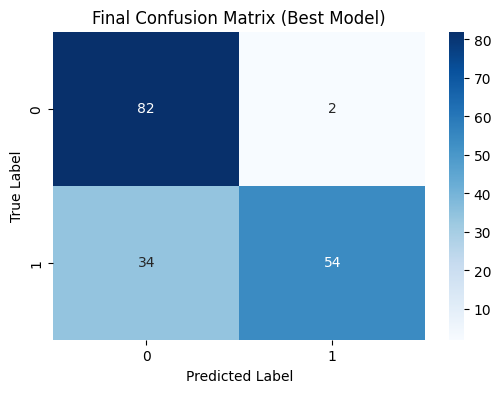

In [21]:
train_and_evaluate_lr("data_train/voice_UCI.csv")
train_and_evaluate_lr("data_train/HandMotion_PaHaW.csv")
train_and_evaluate_lr("data_train/RT_Christina.csv")

In [22]:
# train_and_evaluate_lr("/home/varsallz/Diagnostic_Aid_PD/code/Algorithm/Voice/voice_features/voice_UCI.csv")

In [23]:
# train_and_evaluate_lr("/home/varsallz/Diagnostic_Aid_PD/code/Algorithm/HandMotion/HandMotion_PaHaW.csv")

In [24]:
# train_and_evaluate_lr("/home/varsallz/Diagnostic_Aid_PD/code/Algorithm/tremor/RT_features.csv")

## XGBoost

In [25]:
def train_and_evaluate_xgb(dataset=""):
    if "voice" in dataset: 
        df = pd.read_csv(dataset)
        df = df.drop(columns="voiceID")
    elif "HandMotion" in dataset:
        df = pd.read_csv(dataset)
    else:
        df = pd.read_csv(dataset)
    
    df = df.sample(frac=1).reset_index(drop=True)  # Shuffle dataset
    X = df.drop(columns="label")
    y = df["label"]
    
    param_grid = {
        "n_estimators": [100, 200, 300],
        "max_depth": [3, 6, 10],
        "learning_rate": [0.01, 0.1, 0.2],
        # "subsample": [0.8, 1.0],
        # "colsample_bytree": [0.8, 1.0]
    }
    
    best_model = None
    best_score = 0
    results_list = []

    # Cross-validation with different seeds
    for seed in range(10):
        print(f"\nRunning with seed {seed}...")

        # Split dataset
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed, stratify=y)
        
        # Scale data
        scaler = StandardScaler()
        X_train = scaler.fit_transform(X_train)
        X_test = scaler.transform(X_test)

        # Compute class weights
        class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
        scale_pos_weight = class_weights[1] / class_weights[0]

        # Train the model
        model = xgb.XGBClassifier(scale_pos_weight=scale_pos_weight)
        
        # Specify the eval_set to monitor training and validation loss
        evals_result = {}
        model.fit(X_train, y_train, 
                  eval_set=[(X_train, y_train), (X_test, y_test)], 
                #   eval_metric="logloss", 
                  verbose=False,
                #   evals_result=evals_result
                  )

        # Get predictions and apply a fixed threshold of 0.5
        y_probs = model.predict_proba(X_test)[:, 1]
        y_pred_adjusted = (y_probs > 0.5).astype(int)

        # Evaluate
        accuracy = accuracy_score(y_test, y_pred_adjusted)
        report = classification_report(y_test, y_pred_adjusted, output_dict=True)
        conf_matrix = confusion_matrix(y_test, y_pred_adjusted)

        # Save results
        results_list.append({
            "Seed": seed,
            "Accuracy": accuracy,
            "Precision": report["weighted avg"]["precision"],
            "Recall": report["weighted avg"]["recall"],
            "F1-score": report["weighted avg"]["f1-score"]
        })

        # Update best model if needed
        if accuracy > best_score:
            best_score = accuracy
            best_model = model
            final_conf_matrix = conf_matrix
            if "voice_" in dataset: 
                model_filename = "trained_models/best_XGB_model_voice.pkl"
            elif "HandMotion" in dataset:
                model_filename = "trained_models/best_XGB_model_HM.pkl"
            else:
                model_filename = "trained_models/best_XGB_model_RT.pkl"  # Default case
            with open(model_filename, "wb") as f:
                pickle.dump(best_model, f)  # Save best model

    
    results_df = pd.DataFrame(results_list)
    final_results = results_df.groupby("Seed")["Accuracy"].agg(["mean", "std"])
    print("\nFinal Results Summary:")
    print(final_results)
    # print(f"Best model saved as 'best_lr_model_{dataset}.pkl' with accuracy:", best_overall_score)
    
    if "voice_" in dataset: 
        results_df.to_csv(f"test_results/Int_testing_results_voice_XGB.csv")
    elif "HandMotion" in dataset:
        results_df.to_csv(f"test_results/Int_testing_results_HM_XGB.csv")
    else:
        results_df.to_csv(f"test_results/Int_testing_results_RT_XGB.csv")  # Default case

    # Plot final confusion matrix
    if final_conf_matrix is not None:
        plt.figure(figsize=(6, 4))
        sns.heatmap(final_conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=np.unique(y), yticklabels=np.unique(y))
        plt.xlabel("Predicted Label")
        plt.ylabel("True Label")
        plt.title("Final Confusion Matrix (Best Model)")
        plt.show()

    # Plot Training Loss Curve
    if "validation_0" in evals_result and "validation_1" in evals_result:
        plt.figure(figsize=(8, 5))
        plt.plot(evals_result["validation_0"]["logloss"], label="Train Loss")
        plt.plot(evals_result["validation_1"]["logloss"], label="Validation Loss")
        plt.xlabel("Iterations")
        plt.ylabel("Log Loss")
        plt.title("XGBoost Training Curve")
        plt.legend()
        plt.show()

    # Plot Feature Importance
    plt.figure(figsize=(8, 6))
    xgb.plot_importance(best_model, importance_type="weight", max_num_features=10)
    plt.title("Feature Importance (Top 10)")
    plt.show()



Running with seed 0...

Running with seed 1...

Running with seed 2...

Running with seed 3...

Running with seed 4...

Running with seed 5...

Running with seed 6...

Running with seed 7...

Running with seed 8...

Running with seed 9...

Final Results Summary:
          mean  std
Seed               
0     0.871795  NaN
1     0.948718  NaN
2     0.948718  NaN
3     0.948718  NaN
4     0.923077  NaN
5     0.897436  NaN
6     0.948718  NaN
7     0.948718  NaN
8     0.897436  NaN
9     0.923077  NaN


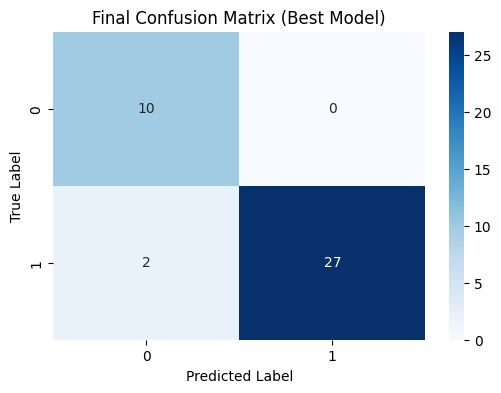

<Figure size 800x600 with 0 Axes>

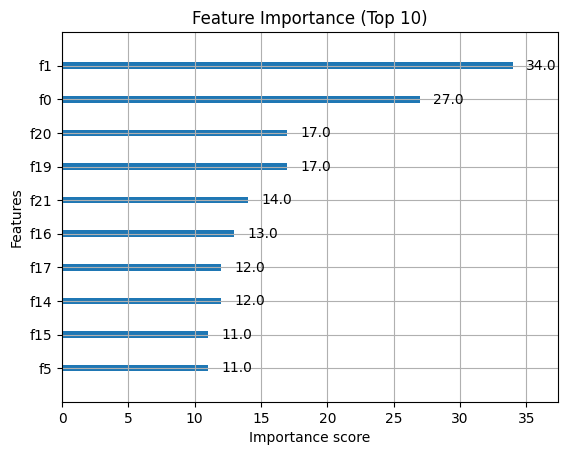


Running with seed 0...

Running with seed 1...

Running with seed 2...

Running with seed 3...

Running with seed 4...

Running with seed 5...

Running with seed 6...

Running with seed 7...

Running with seed 8...

Running with seed 9...

Final Results Summary:
          mean  std
Seed               
0     0.916201  NaN
1     0.888268  NaN
2     0.888268  NaN
3     0.893855  NaN
4     0.849162  NaN
5     0.849162  NaN
6     0.871508  NaN
7     0.877095  NaN
8     0.893855  NaN
9     0.893855  NaN


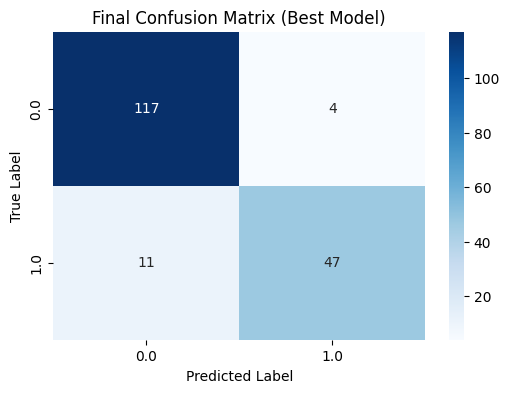

<Figure size 800x600 with 0 Axes>

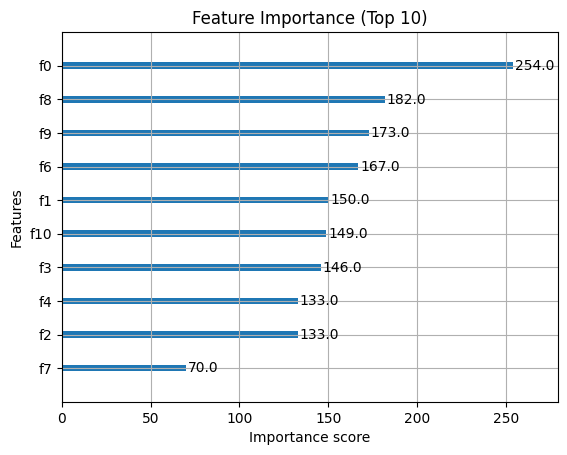


Running with seed 0...

Running with seed 1...

Running with seed 2...

Running with seed 3...

Running with seed 4...

Running with seed 5...

Running with seed 6...

Running with seed 7...

Running with seed 8...

Running with seed 9...

Final Results Summary:
          mean  std
Seed               
0     0.796512  NaN
1     0.767442  NaN
2     0.767442  NaN
3     0.808140  NaN
4     0.779070  NaN
5     0.819767  NaN
6     0.796512  NaN
7     0.738372  NaN
8     0.802326  NaN
9     0.784884  NaN


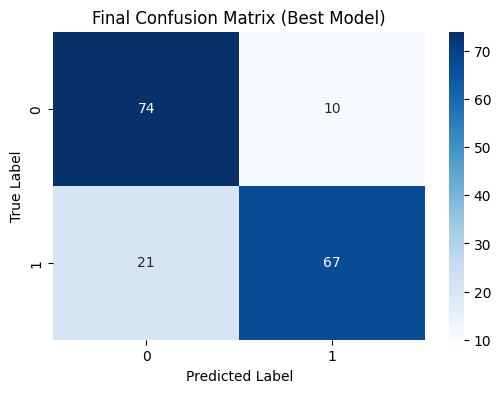

<Figure size 800x600 with 0 Axes>

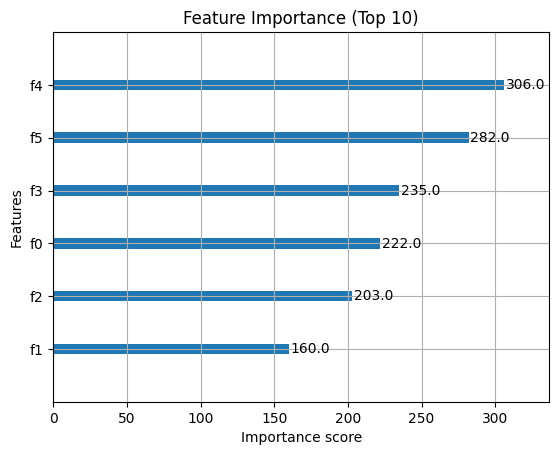

In [26]:
train_and_evaluate_xgb("data_train/voice_UCI.csv")
train_and_evaluate_xgb("data_train/HandMotion_PaHaW.csv")
train_and_evaluate_xgb("data_train/RT_Christina.csv")

In [27]:
# train_and_evaluate_xgb("/home/varsallz/Diagnostic_Aid_PD/code/Algorithm/Voice/voice_features/voice_UCI.csv")

In [28]:
# train_and_evaluate_xgb("/home/varsallz/Diagnostic_Aid_PD/code/Algorithm/HandMotion/HandMotion_PaHaW.csv")


Running with seed 0...

Running with seed 1...

Running with seed 2...

Running with seed 3...

Running with seed 4...

Running with seed 5...

Running with seed 6...

Running with seed 7...

Running with seed 8...

Running with seed 9...

Final Results Summary:
          mean  std
Seed               
0     0.726744  NaN
1     0.767442  NaN
2     0.784884  NaN
3     0.761628  NaN
4     0.767442  NaN
5     0.802326  NaN
6     0.779070  NaN
7     0.755814  NaN
8     0.813953  NaN
9     0.796512  NaN


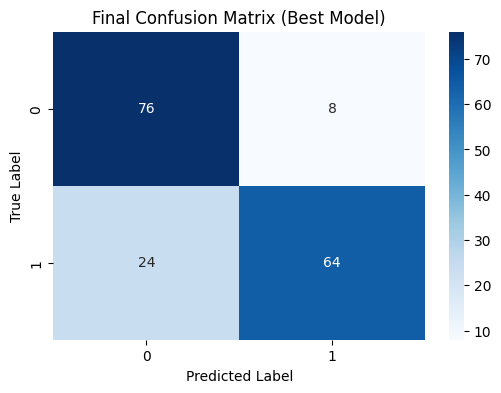

<Figure size 800x600 with 0 Axes>

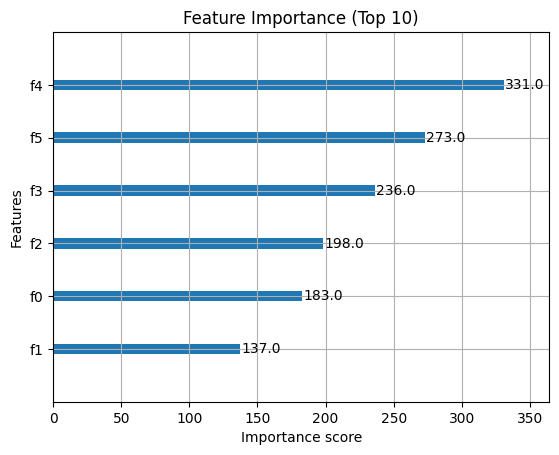

In [29]:
train_and_evaluate_xgb("/home/varsallz/Diagnostic_Aid_PD/code/Algorithm/tremor/RT_features.csv")

## KNN

In [5]:
def train_and_evaluate_knn(dataset=""):
    # Load dataset
    if "voice" in dataset: 
        df = pd.read_csv(dataset)
        df = df.drop(columns="voiceID")
    else:
        df = pd.read_csv(dataset)
    
    df = df.sample(frac=1).reset_index(drop=True)  # Shuffle dataset
    X = df.drop(columns="label")
    y = df["label"]

    best_model = None
    best_score = 0
    results_list = []

    # Define hyperparameter search space for KNN
    param_grid = {"n_neighbors": list(range(1, 30, 2))}

    # Cross-validation with different seeds
    for seed in range(10):
        print(f"\nRunning with seed {seed}...")

        # Split dataset
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed, stratify=y)
        
        # Scale data (KNN is distance-based, so scaling is crucial)
        scaler = MinMaxScaler()
        X_train = scaler.fit_transform(X_train)
        X_test = scaler.transform(X_test)

        if "voice" in dataset: 
            with open("trained_models/scaler_knn_v_2.pkl", "wb") as f:
                pickle.dump(scaler, f)
        elif "HandMotion" in dataset:
            with open("trained_models/scaler_knn_HM.pkl", "wb") as f:
                pickle.dump(scaler, f)
        else:
            with open("trained_models/scaler_knn_RT.pkl", "wb") as f:
                pickle.dump(scaler, f)


        # Hyperparameter tuning using GridSearchCV
        knn = KNeighborsClassifier(weights = "distance")
        grid_search = GridSearchCV(knn, param_grid, cv=5, scoring="precision")
        grid_search.fit(X_train, y_train)

        # Get best model
        best_knn = grid_search.best_estimator_
        best_params = grid_search.best_params_
        print(f"Best Parameters for seed {seed}: {best_params}")

        # Make predictions
        # y_pred = best_knn.predict(X_test)
        y_probs = best_knn.predict_proba(X_test)[:,1]
        threshold =0.8
        y_pred_adjusted = (y_probs > threshold).astype(int)

        # Evaluate
        accuracy = accuracy_score(y_test, y_pred_adjusted)
        report = classification_report(y_test, y_pred_adjusted, output_dict=True)
        conf_matrix = confusion_matrix(y_test, y_pred_adjusted)

        # Save results
        results_list.append({
            "Seed": seed,
            "Accuracy": accuracy,
            "Precision": report["weighted avg"]["precision"],
            "Recall": report["weighted avg"]["recall"],
            "F1-score": report["weighted avg"]["f1-score"]
        })

        # Update best model if needed
        if accuracy > best_score:
            best_score = accuracy
            best_model = best_knn
            final_conf_matrix = conf_matrix
            if "voice_" in dataset: 
                model_filename = "trained_models/new_best_KNN_model_voice.pkl"
            elif "HandMotion" in dataset:
                model_filename = "trained_models/new_best_KNN_model_HM.pkl"
            else:
                model_filename = "trained_models/new_best_KNN_model_RT.pkl"  # Default case
            with open(model_filename, "wb") as f:
                pickle.dump(best_model, f)  # Save best model

    # Convert results to DataFrame
    results_df = pd.DataFrame(results_list)

    # Compute mean and standard deviation of accuracy
    mean_accuracy = results_df["Accuracy"].mean()
    std_accuracy = results_df["Accuracy"].std()

    print("\n=== Final Results Summary ===")
    print(f"Mean Accuracy: {mean_accuracy:.4f}")
    print(f"Standard Deviation of Accuracy: {std_accuracy:.4f}")

    # Save results
    if "voice_" in dataset: 
        results_df.to_csv(f"test_results/Int_testing_results_new_voice_KNN.csv")
    elif "HandMotion" in dataset:
        results_df.to_csv(f"test_results/Int_testing_results_new_HM_KNN.csv")
    else:
        results_df.to_csv(f"test_results/Int_testing_results_new_RT_KNN.csv")  # Default case

    # Plot final confusion matrix
    if best_model is not None:
        plt.figure(figsize=(6, 4))
        sns.heatmap(final_conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=np.unique(y), yticklabels=np.unique(y))
        plt.xlabel("Predicted Label")
        plt.ylabel("True Label")
        plt.title("Final Confusion Matrix (Best Model)")
        plt.show()

    return mean_accuracy, std_accuracy  # Return for further analysis


Running with seed 0...
Best Parameters for seed 0: {'n_neighbors': 1}

Running with seed 1...
Best Parameters for seed 1: {'n_neighbors': 1}

Running with seed 2...
Best Parameters for seed 2: {'n_neighbors': 1}

Running with seed 3...
Best Parameters for seed 3: {'n_neighbors': 1}

Running with seed 4...
Best Parameters for seed 4: {'n_neighbors': 1}

Running with seed 5...
Best Parameters for seed 5: {'n_neighbors': 5}

Running with seed 6...
Best Parameters for seed 6: {'n_neighbors': 1}

Running with seed 7...
Best Parameters for seed 7: {'n_neighbors': 1}

Running with seed 8...
Best Parameters for seed 8: {'n_neighbors': 1}

Running with seed 9...
Best Parameters for seed 9: {'n_neighbors': 1}

=== Final Results Summary ===
Mean Accuracy: 0.9282
Standard Deviation of Accuracy: 0.0397


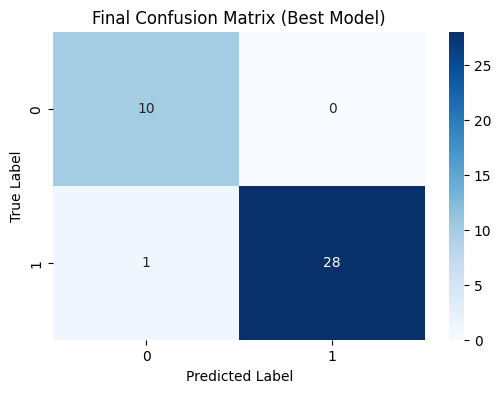

(np.float64(0.9282051282051282), np.float64(0.03972290611494785))

In [6]:
train_and_evaluate_knn("data_train/voice_UCI.csv")

In [ ]:
train_and_evaluate_knn("data_train/voice_UCI.csv")
train_and_evaluate_knn("data_train/HandMotion_PaHaW.csv")
train_and_evaluate_knn("data_train/RT_Christina.csv")

In [31]:
# train_and_evaluate_knn("/home/varsallz/Diagnostic_Aid_PD/code/Algorithm/Voice/voice_features/voice_UCI.csv")

In [32]:
# train_and_evaluate_knn("/home/varsallz/Diagnostic_Aid_PD/code/Algorithm/HandMotion/HandMotion_PaHaW.csv")

In [33]:
# train_and_evaluate_knn("/home/varsallz/Diagnostic_Aid_PD/code/Algorithm/tremor/RT_features.csv")

## NN

2025-03-26 00:16:13.273868: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-03-26 00:16:13.301752: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-03-26 00:16:13.479406: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-03-26 00:16:13.628967: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1742962573.782897    1996 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1742962573.81


Running with seed 0...


/home/varsallz/Diagnostic_Aid_PD/.venv/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
E0000 00:00:1742962578.022294    1996 cuda_executor.cc:1228] INTERNAL: CUDA Runtime error: Failed call to cudaGetRuntimeVersion: Error loading CUDA libraries. GPU will not be used.: Error loading CUDA libraries. GPU will not be used.
W0000 00:00:1742962578.199133    1996 gpu_device.cc:2341] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Seed 0: Accuracy = 0.7949, Precision = 0.8000, Recall = 0.9655, F1-score = 0.8750

Running with seed 1...


/home/varsallz/Diagnostic_Aid_PD/.venv/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Seed 1: Accuracy = 0.8974, Precision = 0.9032, Recall = 0.9655, F1-score = 0.9333

Running with seed 2...


/home/varsallz/Diagnostic_Aid_PD/.venv/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/stepWARNING:tensorflow:6 out of the last 6 calls to <function TensorFlowTrainer.make_predict_function.<locals>.one_step_on_data_distributed at 0x7f29cc7c5ab0> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Seed 2: Accuracy = 0.9487, Precision = 0.9355, Recall = 1.0000, F1-score = 0.9667

Running with seed 3...


/home/varsallz/Diagnostic_Aid_PD/.venv/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Seed 3: Accuracy = 0.8718, Precision = 0.8529, Recall = 1.0000, F1-score = 0.9206

Running with seed 4...


/home/varsallz/Diagnostic_Aid_PD/.venv/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Seed 4: Accuracy = 0.8205, Precision = 0.8235, Recall = 0.9655, F1-score = 0.8889


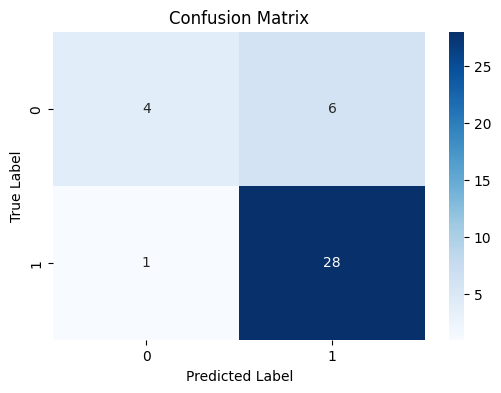


Final Results Summary:
          Seed  Accuracy  Precision    Recall  F1-score
mean  2.000000  0.866667   0.863036  0.979310  0.916905
std   1.581139  0.061217   0.055902  0.018887  0.036404


In [34]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix

def build_model(input_shape):
    """Creates a simple feedforward neural network (MLP) for classification."""
    model = keras.Sequential([
        keras.layers.Dense(64, activation="relu", input_shape=(input_shape,)),
        keras.layers.Dense(32, activation="relu"),
        keras.layers.Dense(1, activation="sigmoid")  # Binary classification
    ])
    model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])
    return model

def plot_confusion_matrix(cm, labels):
    """Plots the confusion matrix."""
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Confusion Matrix")
    plt.show()

def train_and_evaluate_tf(dataset=""):
    if "voice" in dataset: 
        df = pd.read_csv(dataset)
        df = df.drop(columns="voiceID")
    else:
        df = pd.read_csv(dataset)

    # Shuffle dataset
    df = df.sample(frac=1, random_state=42).reset_index(drop=True)
    X = df.drop(columns="label")
    y = df["label"].astype(int)  # Ensure binary labels are integers

    # Store results
    results_list = []

    for seed in range(5):  # Run multiple times to measure std of accuracy
        print(f"\nRunning with seed {seed}...")

        # Split dataset
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed, stratify=y)

        # Scale data
        scaler = MinMaxScaler()
        X_train = scaler.fit_transform(X_train)
        X_test = scaler.transform(X_test)

        # Build and train model
        model = build_model(X_train.shape[1])
        early_stopping = keras.callbacks.EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)
        model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=50, batch_size=32, verbose=0, callbacks=[early_stopping])

        # Evaluate
        y_probs = model.predict(X_test).flatten()
        y_pred = (y_probs > 0.5).astype(int)

        # Calculate metrics
        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred, zero_division=0)
        recall = recall_score(y_test, y_pred, zero_division=0)
        f1 = f1_score(y_test, y_pred, zero_division=0)
        conf_matrix = confusion_matrix(y_test, y_pred)

        results_list.append({
            "Seed": seed,
            "Accuracy": accuracy,
            "Precision": precision,
            "Recall": recall,
            "F1-score": f1
        })

        print(f"Seed {seed}: Accuracy = {accuracy:.4f}, Precision = {precision:.4f}, Recall = {recall:.4f}, F1-score = {f1:.4f}")

        # Plot confusion matrix for last seed
        if seed == 4:  
            plot_confusion_matrix(conf_matrix, labels=np.unique(y))

    # Compute mean & std of metrics
    results_df = pd.DataFrame(results_list)
    final_results = results_df.agg(["mean", "std"])
    print("\nFinal Results Summary:")
    print(final_results)

train_and_evaluate_tf("/home/varsallz/Diagnostic_Aid_PD/code/Algorithm/Voice/voice_features/voice_UCI.csv")



Running with seed 0...


/home/varsallz/Diagnostic_Aid_PD/.venv/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
Seed 0: Accuracy = 0.7263, Precision = 0.7647, Recall = 0.2241, F1-score = 0.3467

Running with seed 1...


/home/varsallz/Diagnostic_Aid_PD/.venv/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
Seed 1: Accuracy = 0.7542, Precision = 0.6944, Recall = 0.4310, F1-score = 0.5319

Running with seed 2...


/home/varsallz/Diagnostic_Aid_PD/.venv/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
Seed 2: Accuracy = 0.6872, Precision = 0.5385, Recall = 0.2414, F1-score = 0.3333

Running with seed 3...


/home/varsallz/Diagnostic_Aid_PD/.venv/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
Seed 3: Accuracy = 0.7765, Precision = 0.6957, Recall = 0.5517, F1-score = 0.6154

Running with seed 4...


/home/varsallz/Diagnostic_Aid_PD/.venv/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
Seed 4: Accuracy = 0.7486, Precision = 0.6667, Recall = 0.4483, F1-score = 0.5361


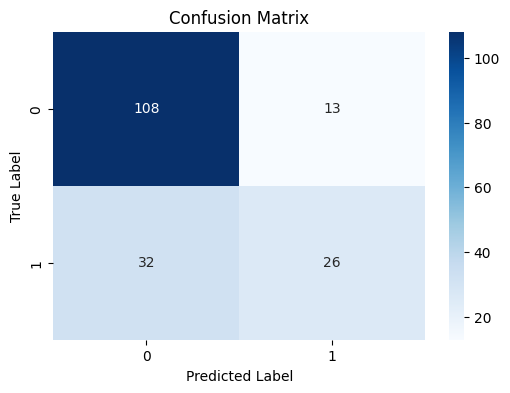


Final Results Summary:
          Seed  Accuracy  Precision    Recall  F1-score
mean  2.000000  0.738547   0.671986  0.379310  0.472676
std   1.581139  0.033844   0.082944  0.141652  0.125688


In [85]:
train_and_evaluate_tf("/home/varsallz/Diagnostic_Aid_PD/code/Algorithm/HandMotion/HandMotion_PaHaW.csv")


Running with seed 0...


/home/varsallz/Diagnostic_Aid_PD/.venv/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
Seed 0: Accuracy = 0.7849, Precision = 0.8923, Recall = 0.6591, F1-score = 0.7582

Running with seed 1...


/home/varsallz/Diagnostic_Aid_PD/.venv/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
Seed 1: Accuracy = 0.7616, Precision = 0.9273, Recall = 0.5795, F1-score = 0.7133

Running with seed 2...


/home/varsallz/Diagnostic_Aid_PD/.venv/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
Seed 2: Accuracy = 0.7558, Precision = 0.8286, Recall = 0.6591, F1-score = 0.7342

Running with seed 3...


/home/varsallz/Diagnostic_Aid_PD/.venv/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
Seed 3: Accuracy = 0.7616, Precision = 0.8730, Recall = 0.6250, F1-score = 0.7285

Running with seed 4...


/home/varsallz/Diagnostic_Aid_PD/.venv/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
Seed 4: Accuracy = 0.7965, Precision = 0.9077, Recall = 0.6705, F1-score = 0.7712


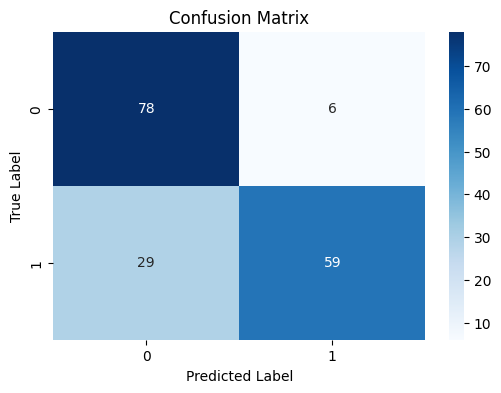


Final Results Summary:
          Seed  Accuracy  Precision    Recall  F1-score
mean  2.000000  0.772093   0.885772  0.638636  0.741071
std   1.581139  0.017635   0.037683  0.037171  0.023349


In [86]:
train_and_evaluate_tf("/home/varsallz/Diagnostic_Aid_PD/code/Algorithm/tremor/RT_features.csv")